In [ ]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
#!pip install bitarray
#!pip install bitsets

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, classification_report

from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

import neural_lib as nl

# Pipeline

In [3]:
df = pd.read_csv('/content/diabetes.csv')
print(df.shape)
df.sample()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
186,8,181,68,36,495,30.1,0.615,60,1


# Step 0. Binarize the data

In [58]:
df_bin = pd.DataFrame()
#1
step = 1
col = 'Pregnancies'
start, finish = 0, 18
for i in range(start, finish, step):
  df_bin[col[0]+'='+str(i)] = df[col] == i
df_bin=df_bin.drop(columns=[col[0]+'=16'])
#2
step = 8
col='Glucose'
start, finish = 40, 200
df_bin[col[0]+'=0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin['G('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#3
step = 20
col = 'BloodPressure'
start, finish = 22, 122
df_bin['BP'+'=0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin['BP'+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#4
step = 15.5
col = 'SkinThickness'
start, finish = 6, 99
df_bin[col[0]+'=0'] = df[col] == 0
for i in np.arange(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#5
step = 139
col = 'Insulin'
start, finish = 12, 846
df_bin[col[0]+'=0'] = df[col] == 0
for i in np.arange(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))

#6
step = 5
col = 'BMI'
start, finish = 18, 67
df_bin[col[0]+'=0'] = df[col] == 0
for i in range(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))
#7
df_bin['DiabetesPedigreeFunction>=1'] = df['DiabetesPedigreeFunction'] >= 1
df_bin['DiabetesPedigreeFunction<1'] = df['DiabetesPedigreeFunction'] < 1
#8
step = 6
col = 'Age'
start, finish = 20, 81
for i in range(start, finish, step):
  df_bin[col[0]+'('+str(i) + ';' + str(i+step) + ']'] = (df[col] >i ) & (df[col] <= (i+step))



df_bin['Outcome'] = df['Outcome'] == 1



In [59]:
df_bin.shape

(768, 83)

In [60]:

df_bin['sample_id'] = np.arange(0, df_bin.shape[0], 1).astype(str)
df_bin['id'] = df_bin['sample_id'].apply(lambda x: 'h' + x)
df_bin.drop(columns=['sample_id'], inplace=True)
df_bin=df_bin.set_index('id')
df_bin.sample()

,P=0,P=1,P=2,P=3,P=4,P=5,P=6,P=7,P=8,P=9,...,A(32;38],A(38;44],A(44;50],A(50;56],A(56;62],A(62;68],A(68;74],A(74;80],A(80;86],Outcome
id,,,,,,,,,,,,,,,,,,,,,
h188,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


Split the data to train and test

In [61]:
y_feat = 'Outcome'
df_train, df_test = train_test_split(df_bin, train_size=0.7, random_state=0)

X_train, y_train = df_train.drop(y_feat, axis=1), df_train[y_feat]
X_test, y_test = df_test.drop(y_feat, axis=1), df_test[y_feat]
X_train.sample()



,P=0,P=1,P=2,P=3,P=4,P=5,P=6,P=7,P=8,P=9,...,A(26;32],A(32;38],A(38;44],A(44;50],A(50;56],A(56;62],A(62;68],A(68;74],A(74;80],A(80;86]
id,,,,,,,,,,,,,,,,,,,,,
h713,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Step 1. Build Monotone Concept Lattice

Put binarized data in FormalContext and compute monotone ConceptLattice

In [62]:
%%time 
K_train = FormalContext.from_pandas(X_train)
K_train

CPU times: user 12.4 ms, sys: 8 µs, total: 12.4 ms
Wall time: 13.3 ms


FormalContext (537 objects, 82 attributes, 4296 connections)
    |P=0|P=1|P=2|P=3|P=4|...|A(56;62]|A(62;68]|A(68;74]|A(74;80]|A(80;86]|
h580|  X|   |   |   |   |...|        |        |        |        |        |
h418|   |  X|   |   |   |...|        |        |        |        |        |
h764|   |   |  X|   |   |...|        |        |        |        |        |
h363|   |   |   |   |  X|...|        |       X|        |        |        |
h757|  X|   |   |   |   |...|        |        |        |        |        |
h636|   |   |   |   |   |...|        |        |        |        |        |
h155|   |   |   |   |   |...|        |        |        |        |        |
h390|   |  X|   |   |   |...|        |        |        |        |        |
h761|   |   |   |   |   |...|        |        |        |        |        |
h358|   |   |   |   |   |...|        |        |        |        |        |
..........................................................................
.......................................

In [64]:
from datetime import datetime

now = datetime.now()

now.strftime("%H:%M:%S")

'13:46:01'

In [65]:
%%time 

L = ConceptLattice.from_context(K_train,algo='Sofia', is_monotone=True)
len(L)

CPU times: user 4min 48s, sys: 1.51 s, total: 4min 50s
Wall time: 4min 52s


100

In [66]:
now = datetime.now()

now.strftime("%H:%M:%S")

'13:50:54'

Compute F1 score for each formal concept  (assuming that an object is predicted True if it is in the extent of the concept)

In [67]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train, y_preds)
    c.measures['recall_score'] = recall_score(y_train, y_preds)

Select indices of the best concepts from the lattice

In [92]:

n_concepts = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:n_concepts])
assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Construct neural network based on concept lattice

In [93]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

Setup visuzalier for the architecture

In [94]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

In [ ]:
set(X_train.columns)

In [95]:
descr = {'G(192;200]'}

traced = cn.trace_description(descr, include_targets=False)

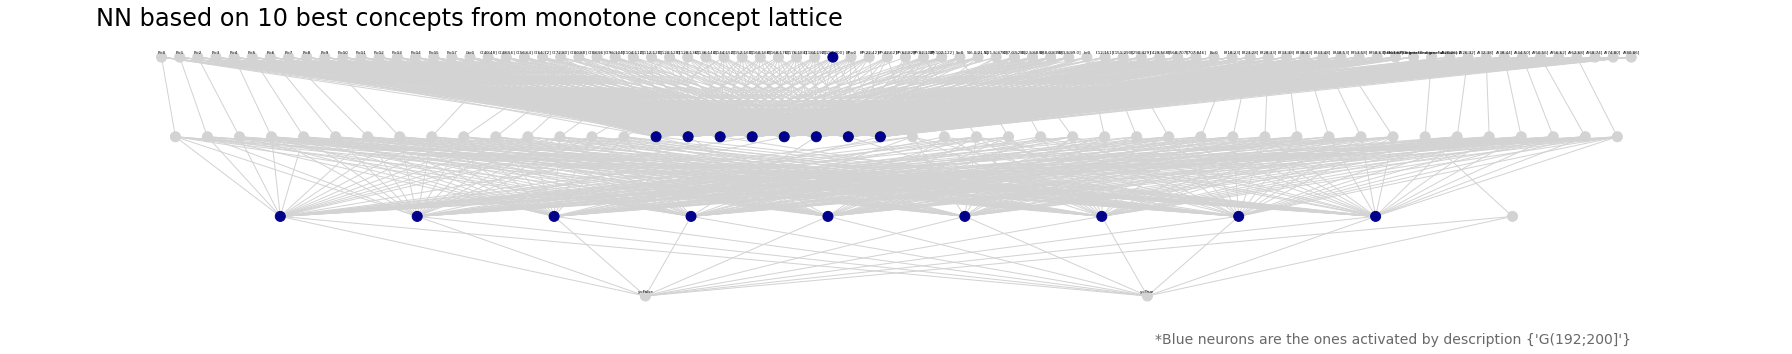

In [97]:
fig, ax = plt.subplots(figsize=(25,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_color=['darkblue' if el_i in traced else 'lightgray' for el_i in range(len(cn.poset))
                ],
               node_size=100,
               node_label_font_size=4.5
)
plt.title(f'NN based on '+str(n_concepts)+' best concepts from monotone concept lattice', loc='left', x=0.05, size=24)

plt.text(max(vis.mover.posx), min(vis.mover.posy)-0.3, f'*Blue neurons are the ones activated by description {descr}', fontsize=14, ha='right', color='dimgray')

plt.subplots_adjust()
plt.tight_layout()
plt.savefig('nn_big_more.png')
plt.show()

Now fit the network

In [98]:
import torch

In [99]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 2000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 1 0 0 1 1 0 1]
Class prediction with probabilities [[4.7890677e-05 9.9995208e-01]
 [1.0000000e+00 1.4230435e-16]
 [6.0214150e-01 3.9785847e-01]
 [3.0822088e-07 9.9999964e-01]
 [1.0000000e+00 5.5256880e-15]
 [1.0000000e+00 2.3502899e-21]
 [2.0148732e-04 9.9979848e-01]
 [5.4361702e-12 1.0000000e+00]
 [9.7035182e-01 2.9648231e-02]
 [2.3242287e-02 9.7675771e-01]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.527027027027027
F1     score: 0.5531914893617023
Accuracy score: 0.7272727272727273


In [100]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 5000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [0 0 0 1 0 0 1 1 0 1]
Class prediction with probabilities [[8.0793101e-01 1.9206901e-01]
 [1.0000000e+00 2.5058602e-16]
 [9.9997246e-01 2.7483587e-05]
 [3.5280910e-16 1.0000000e+00]
 [1.0000000e+00 3.6086227e-13]
 [1.0000000e+00 2.7897426e-19]
 [2.6577823e-10 1.0000000e+00]
 [2.7285815e-27 1.0000000e+00]
 [9.9999464e-01 5.4227880e-06]
 [7.0044422e-03 9.9299556e-01]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.47297297297297297
F1     score: 0.5426356589147288
Accuracy score: 0.7445887445887446


In [101]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 10000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [0 0 0 1 0 0 1 1 0 0]
Class prediction with probabilities [[9.9721825e-01 2.7817702e-03]
 [1.0000000e+00 2.9684590e-23]
 [1.0000000e+00 1.7144642e-15]
 [3.8934788e-14 1.0000000e+00]
 [1.0000000e+00 3.3965952e-17]
 [1.0000000e+00 1.9084611e-23]
 [4.4358051e-09 1.0000000e+00]
 [1.8225114e-31 1.0000000e+00]
 [9.9069059e-01 9.3094585e-03]
 [9.8048133e-01 1.9518649e-02]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.5135135135135135
F1     score: 0.5588235294117647
Accuracy score: 0.7402597402597403


The best result were 2 000 epochs

In [102]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
cn.fit(X_train, y_train,  n_epochs = 10000, nonlinearity=torch.nn.GELU)

y_pred = cn.predict(X_test).numpy()
print('Class prediction', y_pred[:10])
y_proba = cn.predict_proba(X_test).detach().numpy()
print('Class prediction with probabilities', y_proba[:10])
print('True class', y_test.values[:10])

print('Recall score:', recall_score(y_test.values.astype('int'), y_pred))
print('F1     score:', f1_score(y_test.values.astype('int'), y_pred))
print('Accuracy score:', accuracy_score(y_test.values.astype('int'), y_pred))

Class prediction [1 0 0 1 0 0 1 1 0 0]
Class prediction with probabilities [[3.7691043e-05 9.9996233e-01]
 [1.0000000e+00 3.2567024e-12]
 [9.9999976e-01 2.7174627e-07]
 [4.7446229e-03 9.9525529e-01]
 [1.0000000e+00 2.2743418e-09]
 [1.0000000e+00 7.7212327e-11]
 [2.8860534e-04 9.9971133e-01]
 [3.9335544e-18 1.0000000e+00]
 [9.5592749e-01 4.4072498e-02]
 [7.3440140e-01 2.6559862e-01]]
True class [ True False False  True False False  True  True False False]
Recall score: 0.5135135135135135
F1     score: 0.5588235294117647
Accuracy score: 0.7402597402597403


In [103]:
edge_weights = cn.edge_weights_from_network()

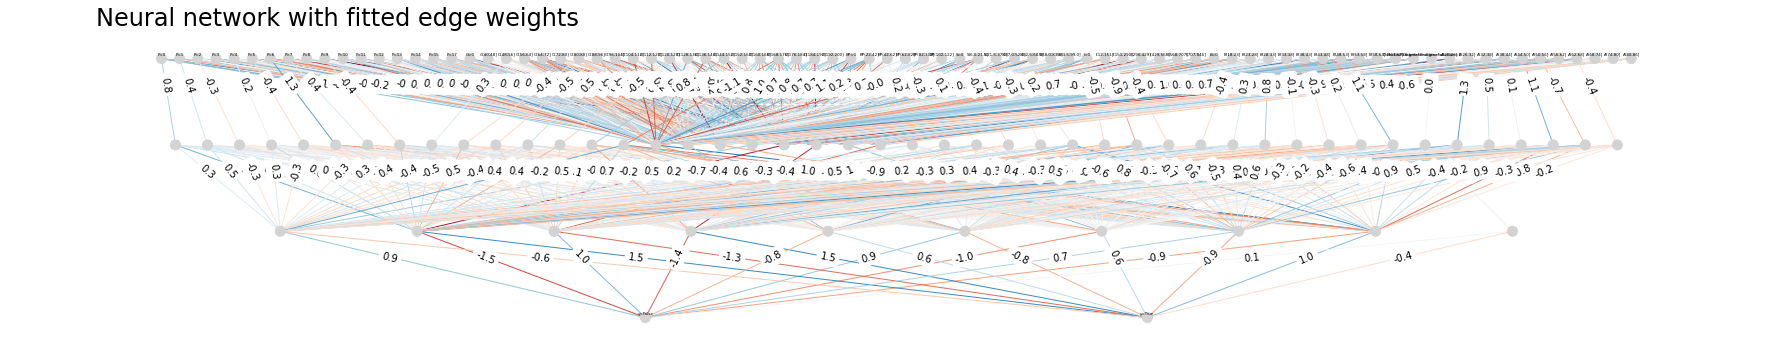

In [104]:
import networkx as nx

fig, ax = plt.subplots(figsize=(25,5))

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
    
               node_size=100,
               node_label_font_size=4.5
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='left')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_big_more.png')
plt.show()